- Groq is a company that develops high-performance hardware and software solutions for AI inference. Their core product, the LPU™   Inference Engine, is designed to accelerate AI tasks, offering significant speed improvements. It provides superior compute power, enabling faster processing of AI models. The platform is optimized for energy efficiency, reducing operational costs. Overall, Groq aims to enhance AI performance across various applications, including machine learning and deep learning workloads.
- https://console.groq.com/playground

In [1]:
import os
from dotenv import load_dotenv
import openai
load_dotenv()

openai.api_key=os.getenv('OPENAI_API_KEY')

groq_api_key=os.getenv('GROQ_API_KEY')

In [2]:
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq

groq_model = ChatGroq(model="gemma2-9b-it",groq_api_key=groq_api_key)

openai_model = ChatOpenAI(model="gpt-4o")


In [3]:
from langchain_core.messages import SystemMessage,AIMessage,HumanMessage

message = [
        SystemMessage("Translate from English to Hindi"),
        HumanMessage(content="Hello how are you")
]

response1 = groq_model.invoke(message)
response2 = openai_model.invoke(message)

print(response1)
print("\n"*2)
print(response2)


content='नमस्ते, आप कैसे हैं? (Namaste, aap kaise hain?) \n' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 18, 'total_tokens': 40, 'completion_time': 0.04, 'prompt_time': 7.714e-05, 'queue_time': 0.022944167, 'total_time': 0.04007714}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None} id='run-37629df0-21be-45b2-b0f6-8452d87f8f89-0' usage_metadata={'input_tokens': 18, 'output_tokens': 22, 'total_tokens': 40}



content='नमस्ते, आप कैसे हैं?' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 20, 'total_tokens': 30, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_4691090a87', 'finish_reason': 'stop',

In [4]:
from langchain_core.output_parsers import StrOutputParser

parser = StrOutputParser()

parser.invoke(response1)

'नमस्ते, आप कैसे हैं? (Namaste, aap kaise hain?) \n'

In [5]:
#using LCEL we can chain the components

In [6]:
chain1= groq_model|parser

print(chain1.invoke(message))

chain2= openai_model|parser

print(chain2.invoke(message))


नमस्ते, आप कैसे हैं? 
(Namaste, aap kaise hain?) 


This is a common and polite way to say "Hello, how are you?" in Hindi.

नमस्ते, आप कैसे हैं?


In [7]:
#another efficient method is using prompt templates

from langchain_core.prompts import ChatPromptTemplate

generic_prompt = "Translate into following {language}"

prompt = ChatPromptTemplate.from_messages([("system",generic_prompt),("user","{text}")])

prompt.invoke({"language":"Hindi","text":"Hello this is shanmukh"})

chain3 = prompt | groq_model | parser

chain3.invoke({"language":"Hindi","text":"Hello this is shanmukh"})



"नमस्ते, मैं शंमुख हूँ। \n \n (Namaste, main Shanmukhu hoon.) \n\n\nLet me know if you'd like me to translate anything else!\n"

In [8]:
%%writefile lama_rag.py

import streamlit as st 
import os
from langchain_groq import ChatGroq
from langchain_openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_community.vectorstores import FAISS  
from langchain_community.document_loaders import PyPDFDirectoryLoader
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains import create_retrieval_chain
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
from langchain_huggingface.embeddings import *


load_dotenv()

groq_api_key=os.getenv('GROQ_API_KEY','xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')

groq_model = ChatGroq(model_name="llama-3.2-1b-preview",groq_api_key=groq_api_key)

generic_prompt = """
                    Answer the following questions based on given context only.
                    Please provide most accurate response based on question.
                    <context>
                    {context}
                    </context>
                """

prompt = ChatPromptTemplate.from_messages([("system",generic_prompt),("user","{input}")])


def create_vector_embeddings_ollama():
    if "vectors" not in st.session_state:
        st.session_state.embeddings = OpenAIEmbeddings()
        st.session_state.loader = PyPDFDirectoryLoader("research") #data ingestion step
        st.session_state.docs  = st.session_state.loader.load() #documents loading
        st.session_state.text_splitter =  RecursiveCharacterTextSplitter(chunk_size=1000,chunk_overlap=200)
        st.session_state.final_documents = st.session_state.text_splitter.split_documents(st.session_state.docs)
        st.session_state.vectors = FAISS.from_documents(st.session_state.final_documents,st.session_state.embeddings)
        
user_prompt = st.text_input("Enter the query from the documents")
if st.button("Document Embedding"):
    create_vector_embeddings_ollama()
    st.write("Vector db is ready")

if user_prompt:
    document_chain = create_stuff_documents_chain(groq_model,prompt)
    retriver  =  st.session_state.vectors.as_retriever()
    retriver_chain = create_retrieval_chain(retriver,document_chain)
    response = retriver_chain.invoke({'input':user_prompt})
    st.write(response['answer'])
    




Overwriting lama_rag.py


In [9]:
import subprocess

process = subprocess.Popen(["streamlit","run","lama_rag.py"])

print("process",process)

process <Popen: returncode: None args: ['streamlit', 'run', 'lama_rag.py']>


In [10]:
process.terminate()

In [11]:
#Conversation_rag using Message History lama3

In [66]:

%%writefile lama_conversational_rag.py

import streamlit as st 
import os
from langchain_groq import ChatGroq
from langchain_openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from datetime import datetime 
import pandas as pd
from langchain_community.document_loaders import PyPDFLoader
import random
from langchain_chroma import Chroma
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from io import StringIO
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain.memory import ChatMessageHistory
import shutil
import chromadb


#If there is no chat_history, then the input is just passed directly to the retriever. If there is chat_history, then the prompt and LLM will be used to generate a search query. That search query is then passed to the retriever.
#create_history_aware_retriever
#A history-aware retriever in LangChain is essential to provide contextually relevant responses by considering previous interactions. It ensures continuity in multi-turn conversations, allowing the model to retrieve more accurate information based on both the current and past queries. This enhances personalization and efficiency in ongoing dialogues.

from langchain.chains import create_history_aware_retriever
from langchain_core.prompts import MessagesPlaceholder
from langchain_core.prompts import ChatPromptTemplate

from dotenv import load_dotenv
collection_name = "your_collection_name"



load_dotenv()

groq_api_key=os.getenv('GROQ_API_KEY','xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')

groq_model = ChatGroq(model_name="llama-3.1-8b-instant",groq_api_key=groq_api_key)

import random
import streamlit as st
from langchain_community.document_loaders import PyPDFLoader  # Correct import from langchain

from langchain.embeddings import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma

delete_session = st.button(label="Delete Session", type="secondary", icon=None, disabled=False, use_container_width=False)


if delete_session:
    st.session_state.clear()
    st.write("Session cleared")

    
def read_documents():
    uploaded_files=[]
    uploaded_files = st.file_uploader(label="Please upload PDF files", type=['pdf'], accept_multiple_files=True)
    if uploaded_files and 'read' not in st.session_state:
        documents = []    
        # Loop through uploaded files and extract pages
        persist_directory = r'D:\PROJECT_PRACTISE_DIRS\GenAI\Chroma'
        temporary_file = persist_directory + "\\" + "tempo" + str(random.randint(1,1000)) + ".pdf"
        file_path = temporary_file
        for uploaded_file in uploaded_files:
            # Load the PDF directly from memory
            bytes_data = uploaded_file.getvalue()
            
            with open(temporary_file,'wb') as file:
                file.write(bytes_data)
                loader = PyPDFLoader(file_path)
            
            documents.extend(loader.load())

        # Prepare embeddings and text splitting
        st.session_state.embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
        st.session_state.text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
        
        # Split documents into chunks
        st.session_state.final_documents = st.session_state.text_splitter.split_documents(documents)
        
        # Display for debugging purposes (optional)
        
        # Create vector store and retriever
        persist_directory='D:\\PROJECT_PRACTISE_DIRS\\GenAI\\Chroma'
        collection_name = "Chroma"

        st.session_state.vectors = Chroma.from_documents(st.session_state.final_documents, st.session_state.embeddings,collection_name=collection_name,persist_directory=persist_directory)
        st.session_state.retreiver = st.session_state.vectors.as_retriever()
        st.session_state.read = True
        
        return st.session_state.read  # Indicating that documents have been read

    elif uploaded_files and st.session_state.read:
        st.write("Already Embedded no need to read")
        return st.session_state.read
    else:
        return False 

def get_session_history(session_id: str):
    if 'store' not in st.session_state:
        st.session_state.store = {}
    if session_id not in st.session_state.store:
        st.session_state.store[session_id]=ChatMessageHistory()
            
    return st.session_state.store[session_id]
        

result = read_documents()
if result:
    import random
    session_history=get_session_history('abc7')
    
    user_input = st.text_input("Your question:")
    session_history.add_user_message(user_input)
    if user_input:
        contextualize_q_system_prompt = (
            "Given a chat history and the latest user question "
            "which might reference context in the chat history, "
            "formulate a standalone question which can be understood "
            "without the chat history. Do NOT answer the question, "
            "just reformulate it if needed and otherwise return it as is."
        )


        contextualize_q_prompt = ChatPromptTemplate.from_messages(
            [
                ("system", contextualize_q_system_prompt),
                MessagesPlaceholder(variable_name="chat_history"),
                ("human", "{input}"),
            ]
        )
        #Create a chain that takes conversation history and returns documents.
        #https://api.python.langchain.com/en/latest/chains/langchain.chains.history_aware_retriever.create_history_aware_retriever.html


        history_aware_retriever = create_history_aware_retriever(groq_model, st.session_state.retreiver, contextualize_q_prompt)

        system_prompt = (
            "You are an assistant for question-answering tasks. "
            "Use the following pieces of retrieved context to answer "
            "the question. If you don't know the answer, say that you "
            "don't know. Use three sentences maximum and keep the "
            "answer concise."
            "\n\n"
            "{context}"
        )   

        prompt = ChatPromptTemplate.from_messages(
            [
                ("system", system_prompt),
                MessagesPlaceholder("chat_history"),
                ("human", "{input}"),
            ]
        )

        #Create a chain for passing a list of Documents to a model.

        question_answer_chain = create_stuff_documents_chain(groq_model, prompt)

        #Create retrieval chain that retrieves documents and then passes them on.


        rag_chain = create_retrieval_chain(history_aware_retriever, question_answer_chain)

        conversational_rag_chain = RunnableWithMessageHistory(
            rag_chain,
            get_session_history,
            input_messages_key="input",
            history_messages_key="chat_history",
            output_messages_key="answer",
        )
        
        response = conversational_rag_chain.invoke(
            {"input": user_input},
            config={
                "configurable": {"session_id":"abc7"}
            },  # constructs a key "abc123" in `store`.
        )

        st.write("Assistant:", response['answer'])


Overwriting lama_conversational_rag.py


In [65]:
import subprocess

process = subprocess.Popen(["streamlit","run","lama_conversational_rag.py"])
print("process",process)

process <Popen: returncode: None args: ['streamlit', 'run', 'lama_conversational_rag...>


In [64]:
process.terminate()

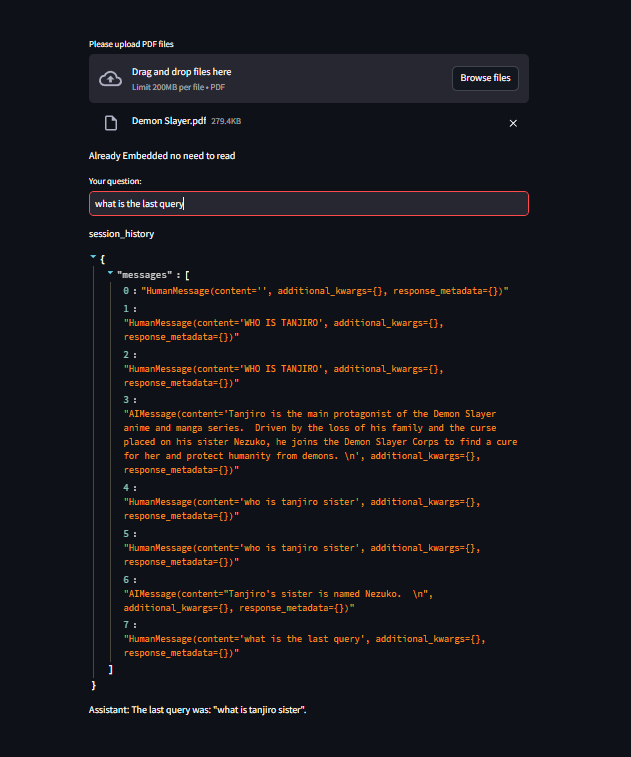

In [16]:
#Output Response
from IPython.display import display, Image

# Display an image with more control
display(Image(filename='session_memory_chatbot.png'))
